In [1]:
from KNN_KDE_Bagging_Imputer import KKBImputer
import matplotlib.pyplot as plt
from utils import select_param_rmse_b,knnxkde_param_rmse
from utils import introduce_miss
from utils import normalization,renormalization
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from knnxkde import KNNxKDE
from sklearn.model_selection import GridSearchCV, KFold
import time

In [2]:
np.set_printoptions(suppress=True)

# sine

In [3]:
np.random.seed(42)
u = np.random.uniform(0,1,4000)+np.random.normal(0, 0.05, 4000)
x1_sine = 4*np.pi*u
x2_sine = np.sin(x1_sine)+np.random.normal(0,0.2,4000)
data_sine = np.vstack((x1_sine,x2_sine)).T
missing_data_sine = data_sine.copy()
missing_data_sine[:1500,0] = np.nan
#Generate new_data
u_new = np.random.uniform(0,1,1000)+np.random.normal(0, 0.05, 1000)
x_new_sine = 4*np.pi*u_new
y_new_sine = np.sin(x_new_sine)+np.random.normal(0,0.2,1000) 

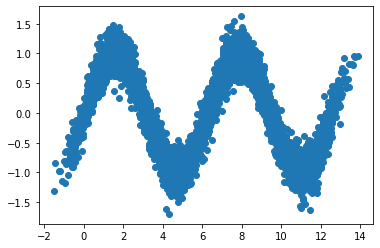

In [4]:
plt.scatter(data_sine[:,0],data_sine[:,1])
plt.show()

In [5]:
norm_miss_data,norm_params = normalization(missing_data_sine)
norm_test_data,_ = normalization(np.vstack((x_new_sine,y_new_sine)).T,parameters=norm_params)
norm_original_data,_ = normalization(data_sine,parameters=norm_params)

In [55]:
np.random.seed(42)
select_param_rmse_b(norm_miss_data[1500:],norm_miss_data[:1500],
                    [5,10],#B
                    [0.2,0.4,0.6,0.8],#s
                    [0.002,0.004,0.006,0.008],#k
                    [0.0002,0.0004,0.0006,0.0008,0.002,0.004],
                    [0.008])


B: 5 => B: 10 => {'B': 5, 's': 0.2, 'k': 0.006, 'h': 0.002, 'K': 0.008} 0.05892489260165865


({'B': 5, 's': 0.2, 'k': 0.006, 'h': 0.002, 'K': 0.008}, 0.05892489260165865)

In [60]:
np.random.seed(42)
result = []
training_duration = []
for i in range(20):
    start_time = time.time()
    imputer = KKBImputer(B=5, s_ratio=0.2, n_neighbors_ratio=0.006, h=0.002)
    imp_data_sine= imputer.impute_pattern(norm_miss_data)
    best_k =int(round(0.008*imp_data_sine.shape[0]))
    knn_regressor = KNeighborsRegressor(n_neighbors=best_k)
    knn_regressor.fit(imp_data_sine[:,:-1],imp_data_sine[:,-1])
    end_time = time.time()
    training_duration.append(end_time - start_time)
    y_pred = knn_regressor.predict(norm_test_data[:,0].reshape(-1,1))
    result.append(np.sqrt(mean_squared_error(norm_test_data[:,1], y_pred)))
print('the rmse using knn_kde_bagging is ',sum(result)/len(result))
print("Imputinga and Training took average {:.2f} seconds".format(sum(training_duration)/len(training_duration)))

the rmse using knn_kde_bagging is  0.06380306780935022
Imputinga and Training took average 0.70 seconds


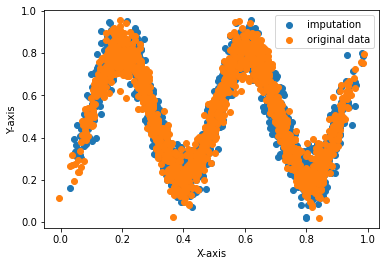

In [57]:
np.random.seed(42)
imputer = KKBImputer(B=5, s_ratio=0.2, n_neighbors_ratio=0.006, h=0.002)
imp_data_sine= imputer.impute_pattern(norm_miss_data)
plt.scatter(imp_data_sine[-1500:,0],imp_data_sine[-1500:,1],label = 'imputation')
plt.scatter(norm_original_data[:1500,0],norm_original_data[:1500,1],label = 'original data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

In [28]:
np.random.seed(42)
knnxkde_param_rmse(norm_miss_data[1500:],norm_miss_data[:1500],
                   [10.0, 50.0, 100.0, 250.0, 500.0,800.0, 1000.0],
                   [0.01,0.03,0.1,0.2,0.05],
                   [0.004,0.008,0.01,0.012,0.016])

tau: 10.0 => tau: 50.0 => tau: 100.0 => tau: 250.0 => tau: 500.0 => tau: 800.0 => tau: 1000.0 => 

({'tau': 800.0, 'h': 0.01, 'K': 0.008}, 0.05922838801322108)

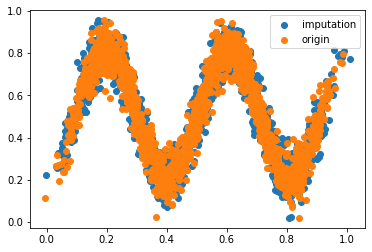

In [15]:
np.random.seed(42)
knnxkde = KNNxKDE(h=0.01, tau=1.0/1000.0, metric='nan_std_eucl')
imputed_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=1)
x_inside = []
y_inside = []
for i in np.where(np.isnan(missing_data_sine))[0]:
    cur_sample = np.random.choice(imputed_samples[(i, 0)], size=1, replace=False)
    y_scatter = [norm_miss_data[i, 1]]
    x_inside.append(cur_sample)
    y_inside.append(y_scatter)
plt.scatter(x_inside, y_inside, label='imputation')
    #plt.scatter(cur_sample, y_scatter, s=45, alpha=0.3, c='C1')
plt.scatter(norm_original_data[np.where(np.isnan(missing_data_sine))[0],0],
            norm_original_data[np.where(np.isnan(missing_data_sine))[0],1],label = 'origin')

plt.legend()
plt.show()

In [61]:
np.random.seed(42)
result = []
training_duration = []
for i in range(20):
    start_time = time.time()
    knnxkde = KNNxKDE(h=0.01, tau=1.0/800.0, metric='nan_std_eucl')
    m_data = norm_miss_data.copy()
    imputed_samples = knnxkde.impute_samples(m_data, nb_draws=1)
    nan_indices = np.where(np.isnan(norm_miss_data))[0]
    x = np.array(list(imputed_samples.values())).reshape(-1)
    m_data[nan_indices,0] = x
    knn_regressor = KNeighborsRegressor(n_neighbors=int(round(0.008*m_data.shape[0])))#if n_neighbors to 18,rmse would be better
    knn_regressor.fit(m_data[:,0].reshape(-1,1),m_data[:,1])
    end_time = time.time()
    training_duration.append(end_time - start_time)
    y_pred = knn_regressor.predict(norm_test_data[:,0].reshape(-1,1))
    result.append(np.sqrt(mean_squared_error(norm_test_data[:,1], y_pred)))
print('rmse with knnxkde is',sum(result)/len(result))
print("Imputinga and Training took average {:.2f} seconds".format(sum(training_duration)/len(training_duration)))

rmse with knnxkde is 0.06379964562789485
Imputinga and Training took average 0.51 seconds


In [27]:
knn_regressor = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 25)}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn_regressor, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(norm_miss_data[1500:,:-1],norm_miss_data[1500:,-1])
best_k = grid_search.best_params_['n_neighbors']
best_score = -grid_search.best_score_
print(f'Best k: {best_k}, Best Mean Squared Error: {best_score}')
best_model = grid_search.best_estimator_

Best k: 24, Best Mean Squared Error: 0.00354284613819536


In [29]:
best_k = 24  # Replace with the best k value from your grid search
knn_regressor = KNeighborsRegressor(n_neighbors=best_k)

# Train the model on the training data
knn_regressor.fit(norm_miss_data[1500:,:-1],norm_miss_data[1500:,-1])

# Make predictions on the new data
y_pred = knn_regressor.predict(norm_test_data[:,0].reshape(-1,1))
print('rmse without any imputation',np.sqrt(mean_squared_error(norm_test_data[:,1], y_pred)))

rmse without any imputation 0.06398127682319926


# ring

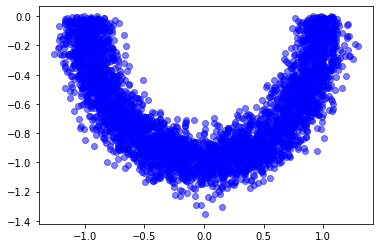

In [6]:
np.random.seed(42)
theta = np.random.uniform(np.pi,2*np.pi,4000)
epsilon = np.random.normal(0,0.1,4000)
r = 1+epsilon
x1_ring = r*np.cos(theta)
x2_ring = r*np.sin(theta)
data_ring = np.vstack((x1_ring,x2_ring)).T
missing_data_ring = data_ring.copy()
missing_data_ring[:2000,0] = np.nan#2000 complete data,2000 missing data


#generate new data
theta_new = np.random.uniform(np.pi,2*np.pi,300)
epsilon_new = np.random.normal(0,0.1,300)
r = 1+epsilon_new
x1_new_ring = r*np.cos(theta_new)
x2_new_ring = r*np.sin(theta_new)

plt.scatter(data_ring[:, 0], data_ring[:, 1], color='blue', label='original',alpha = 0.5)
plt.show()

In [18]:
norm_missing_data_ring,norm_params = normalization(missing_data_ring)
norm_test_data_ring,_ = normalization(np.vstack((x1_new_ring,x2_new_ring)).T,parameters=norm_params)
norm_data_ring,_ = normalization(data_ring,parameters=norm_params)

In [32]:
select_param_rmse_b(norm_missing_data_ring[2000:],norm_missing_data_ring[:2000],
                    [5,10,15],#B
                    [0.6,0.8,0.85,0.9,0.95],#s
                    [0.005,0.01,0.06,0.08,0.09,0.12],#k
                    [0.0001,0.0005,0.001,0.004],
                    [0.064])

B: 5 => B: 10 => B: 15 => {'B': 5, 's': 0.85, 'k': 0.005, 'h': 0.001, 'K': 0.064} 0.11780349071791722


({'B': 5, 's': 0.85, 'k': 0.005, 'h': 0.001, 'K': 0.064}, 0.11780349071791722)

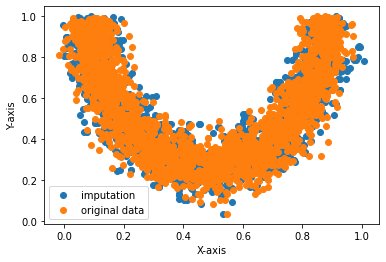

the rmse using knn_kde_bagging is  0.11713945330402735
Imputation and Training took average 0.83 seconds


In [62]:
np.random.seed(42)
# Randomly Draw a imputation data pic
imputer = KKBImputer(B=5, s_ratio=0.85, n_neighbors_ratio=0.005, h=0.001)
imp_data_ring= imputer.impute_row(norm_missing_data_ring)
plt.scatter(imp_data_ring[2000:,0],imp_data_ring[2000:,1],label = 'imputation')
plt.scatter(norm_data_ring[:2000,0],norm_data_ring[:2000,1],label = 'original data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

#repeat the test for 20 times
result = []
training_duration = []
for i in range(20):
    start_time = time.time()
    imputer = KKBImputer(B=5, s_ratio=0.85, n_neighbors_ratio=0.005, h=0.001)
    imp_data_ring= imputer.impute_pattern(norm_missing_data_ring)
    best_k = int(round(imp_data_ring.shape[0]*0.064))
    knn_regressor = KNeighborsRegressor(n_neighbors=best_k)
    knn_regressor.fit(imp_data_ring[:,:-1],imp_data_ring[:,-1])
    end_time = time.time()
    training_duration.append(end_time - start_time)
    y_pred = knn_regressor.predict(norm_test_data_ring[:,:-1])
    result.append(np.sqrt(mean_squared_error(norm_test_data_ring[:,-1], y_pred)))
print('the rmse using knn_kde_bagging is ',sum(result)/len(result))
print("Imputation and Training took average {:.2f} seconds".format(sum(training_duration)/len(training_duration)))

In [34]:
np.random.seed(42)
knnxkde_param_rmse(norm_missing_data_ring[2000:],norm_missing_data_ring[:2000],
                   [10.0,50.0, 100.0, 250.0, 500.0,800.0, 1000.0,1100.0],
                   [0.01,0.03,0.1,0.2,0.05],
                   [0.012,0.016,0.032,0.064,0.128])

tau: 10.0 => tau: 50.0 => tau: 100.0 => tau: 250.0 => tau: 500.0 => tau: 800.0 => tau: 1000.0 => tau: 1100.0 => 

({'tau': 1000.0, 'h': 0.01, 'K': 0.064}, 0.11790703237930751)

In [63]:
np.random.seed(42)
result = []
training_duration = []
for i in range(20):
    start_time = time.time()
    knnxkde = KNNxKDE(h=0.01, tau=1.0/1000.0, metric='nan_std_eucl')
    imputed_samples = knnxkde.impute_samples(norm_missing_data_ring, nb_draws=1)
    m_data = norm_missing_data_ring.copy()
    nan_indices = np.where(np.isnan(norm_missing_data_ring))[0]
    x = np.array(list(imputed_samples.values())).reshape(-1)
    m_data[nan_indices,0] = x
    knn_regressor = KNeighborsRegressor(n_neighbors=int(round(m_data.shape[0]*0.064)))#if n_neighbors to 18,rmse would be better
    knn_regressor.fit(m_data[:,0].reshape(-1,1),m_data[:,1])
    end_time = time.time()
    training_duration.append(end_time - start_time)
    y_pred = knn_regressor.predict(norm_test_data_ring[:,:-1])
    result.append(np.sqrt(mean_squared_error(norm_test_data_ring[:,-1], y_pred)))
print('rmse with knnxkde is',sum(result)/len(result))
print("Imputation and Training took average {:.2f} seconds".format(sum(training_duration)/len(training_duration)))

rmse with knnxkde is 0.11731021235007008
Imputation and Training took average 0.66 seconds


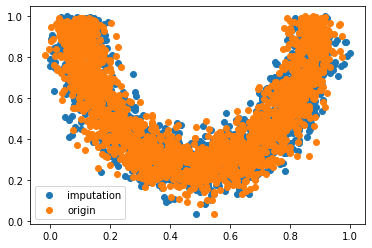

In [64]:
np.random.seed(42)
knnxkde = KNNxKDE(h=0.01, tau=1.0/1000.0, metric='nan_std_eucl')
imputed_samples = knnxkde.impute_samples(norm_missing_data_ring, nb_draws=1)
x_inside = []
y_inside = []
for i in np.where(np.isnan(norm_missing_data_ring))[0]:
    cur_sample = np.random.choice(imputed_samples[(i, 0)], size=1, replace=False)
    y_scatter = [norm_missing_data_ring[i, 1]]
    x_inside.append(cur_sample)
    y_inside.append(y_scatter)
plt.scatter(x_inside, y_inside, label='imputation')
    #plt.scatter(cur_sample, y_scatter, s=45, alpha=0.3, c='C1')
plt.scatter(norm_data_ring[np.where(np.isnan(norm_missing_data_ring))[0],0],
            norm_data_ring[np.where(np.isnan(norm_missing_data_ring))[0],1],label = 'origin')

plt.legend()
plt.show()

# linear

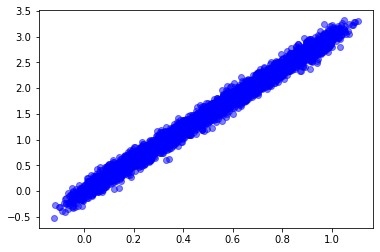

In [65]:
np.random.seed(42)
x1_line = np.random.uniform(0,1,4000)+np.random.normal(0, 0.05, 4000)
x2_line = 3*x1_line+np.random.normal(0,0.1,4000)
data_line = np.vstack((x1_line,x2_line)).T
data_line_miss = data_line.copy()
data_line_miss[:1500,0] = np.nan #2500条完整数据，1500条缺失数据

# Generate Test Set
x1_line_new = np.random.uniform(0,1,1000)+np.random.normal(0, 0.05, 1000)
x2_line_new = 3*x1_line_new+np.random.normal(0,0.1,1000)

plt.scatter(data_line[:, 0], data_line[:, 1], color='blue', label='original',alpha = 0.5)
plt.show()

In [66]:
norm_missing_data_line,norm_params = normalization(data_line_miss)
norm_test_data_line,_ = normalization(np.vstack((x1_line_new,x2_line_new)).T,parameters=norm_params)
norm_data_line,_ = normalization(data_line,parameters=norm_params)

In [69]:
select_param_rmse_b(norm_missing_data_line[1500:],norm_missing_data_line[:1500],
                    [5,10],#B
                    [0.4,0.6,0.8,0.9],#s
                    [0.001,0.002,0.004,0.008,0.016],#k
                    [0.05,0.1,0.25,0.5,1],
                    [0.005,0.01,0.05,0.1])

B: 5 => B: 10 => 

({'B': 10, 's': 0.6, 'k': 0.008, 'h': 0.5, 'K': 0.01}, 0.025326189040125617)

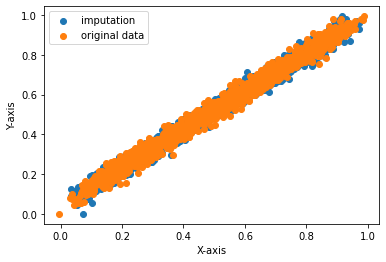

the rmse using knn_kde_bagging is  0.02746485190425379
Imputation and Training took average 1.32 seconds


In [67]:
np.random.seed(42)
# Randomly Draw a imputation data pic
imputer = KKBImputer(B=5, s_ratio=0.6, n_neighbors_ratio=0.008, h=0.1)
imp_data_line= imputer.impute_pattern(norm_missing_data_line)
plt.scatter(imp_data_line[-1500:,0],imp_data_line[-1500:,1],label = 'imputation')
plt.scatter(norm_data_line[:1500,0],norm_data_line[:1500,1],label = 'original data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


result = []
training_duration = []
for i in range(20):
    start_time = time.time()
    imputer = KKBImputer(B=5, s_ratio=0.6, n_neighbors_ratio=0.008,h=0.1)
    imp_data_line= imputer.impute_row(norm_missing_data_line)
    best_k = int(round(imp_data_line.shape[0]*0.01))
    knn_regressor = KNeighborsRegressor(n_neighbors=best_k)
    knn_regressor.fit(imp_data_line[:,:-1],imp_data_line[:,-1])
    end_time = time.time()
    training_duration.append(end_time - start_time)
    y_pred = knn_regressor.predict(norm_test_data_line[:,:-1])
    result.append(np.sqrt(mean_squared_error(norm_test_data_line[:,-1], y_pred)))
print('the rmse using knn_kde_bagging is ',sum(result)/len(result))
print("Imputation and Training took average {:.2f} seconds".format(sum(training_duration)/len(training_duration)))

In [71]:
np.random.seed(42)
knnxkde_param_rmse(norm_missing_data_line[1500:],norm_missing_data_line[:1500],
                   [10.0,50.0, 100.0, 250.0, 500.0,800.0, 1000.0,1100.0],
                   [0.01,0.03,0.1,0.2,0.05],
                   [0.005,0.01,0.05,0.1])

tau: 10.0 => tau: 50.0 => tau: 100.0 => tau: 250.0 => tau: 500.0 => tau: 800.0 => tau: 1000.0 => tau: 1100.0 => 

({'tau': 800.0, 'h': 0.01, 'K': 0.01}, 0.025449875045818294)

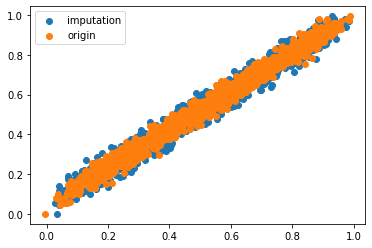

rmse with knnxkde is 0.027538690279880845
Imputation and Training took average 0.47 seconds


In [82]:
np.random.seed(42)
knnxkde = KNNxKDE(h=0.01, tau=1.0/500.0, metric='nan_std_eucl')
imputed_samples = knnxkde.impute_samples(norm_missing_data_line, nb_draws=100)
x_inside = []
y_inside = []
for i in np.where(np.isnan(norm_missing_data_line))[0]:
    cur_sample = np.random.choice(imputed_samples[(i, 0)], size=1, replace=False)
#     m1 = norm_params['min_val'][0]
#     m2 = norm_params['max_val'][0]
#     cur_sample = cur_sample * (m2 + 1e-6) + m1
    y_scatter = [norm_missing_data_line[i, 1]]
    x_inside.append(cur_sample)
    y_inside.append(y_scatter)
plt.scatter(x_inside, y_inside, label='imputation')
    #plt.scatter(cur_sample, y_scatter, s=45, alpha=0.3, c='C1')
plt.scatter(norm_data_line[np.where(np.isnan(norm_missing_data_line))[0],0],
            norm_data_line[np.where(np.isnan(norm_missing_data_line))[0],1],label = 'origin',)

plt.legend()
plt.show()

result = []
training_duration = []
for i in range(20):
    start_time = time.time()
    m_data = norm_missing_data_line.copy()
    knnxkde = KNNxKDE(h=0.01, tau=1.0/500.0, metric='nan_std_eucl')
    imputed_samples = knnxkde.impute_samples(norm_missing_data_line, nb_draws=1)
    nan_indices = np.where(np.isnan(norm_missing_data_line))[0]
    x = np.array(list(imputed_samples.values())).reshape(-1)
    m_data[nan_indices,0] = x
    knn_regressor = KNeighborsRegressor(n_neighbors=int(round(m_data.shape[0]*0.01)))#if n_neighbors to 18,rmse would be better
    knn_regressor.fit(m_data[:,0].reshape(-1,1),m_data[:,1])
    end_time = time.time()
    training_duration.append(end_time - start_time)
    y_pred = knn_regressor.predict(norm_test_data_line[:,:-1])
    result.append(np.sqrt(mean_squared_error(norm_test_data_line[:,-1], y_pred)))
print('rmse with knnxkde is',sum(result)/len(result))
print("Imputation and Training took average {:.2f} seconds".format(sum(training_duration)/len(training_duration)))